In [14]:
pip install -qq wandb matplotlib tqdm diffusers transformers accelerate datasets safetensors peft

Note: you may need to restart the kernel to use updated packages.


In [1]:
from tqdm.auto import tqdm

import pandas as pd 
import numpy as np
import re

import csv
import os
import torch
from PIL import Image
from diffusers import StableDiffusionPipeline, LCMScheduler, UNet2DConditionModel, DDIMScheduler, DDPMScheduler
from transformers import AutoTokenizer

from torch.utils.data import Dataset
from torch.optim import AdamW
from transformers import get_scheduler
import torchvision

from peft import LoraConfig, get_peft_model, get_peft_model_state_dict

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
class COCODataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, subset_name="train2014_5k", transform=None, max_cnt=None):
        """
        Arguments:
            root_dir (string): Директория с картинками
            transform (callable, optional): преобразования, применимые к картинкам
        """
        self.root_dir = root_dir
        self.transform = transform
        self.extensions = (
            ".jpg",
            ".jpeg",
            ".png",
            ".ppm",
            ".bmp",
            ".pgm",
            ".tif",
            ".tiff",
            ".webp",
        )
        sample_dir = os.path.join(root_dir, subset_name)

        # Собираем пути до картинок
        self.samples = sorted(
            [
                os.path.join(sample_dir, fname)
                for fname in os.listdir(sample_dir)
                if fname[-4:] in self.extensions
            ],
            key=lambda x: x.split("/")[-1].split(".")[0],
        )
        self.samples = (
            self.samples if max_cnt is None else self.samples[:max_cnt]
        )  #

        # Собираем промпты
        self.captions = {}
        with open(
            os.path.join(root_dir, f"{subset_name}.csv"), newline="\n"
        ) as csvfile:
            spamreader = csv.reader(csvfile, delimiter=",")
            for i, row in enumerate(spamreader):
                if i == 0:
                    continue
                self.captions[row[1]] = row[2]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample_path = self.samples[idx]
        sample = Image.open(sample_path).convert("RGB")

        if self.transform:
            sample = self.transform(sample)

        return {
            "image": sample,
            "text": self.captions[os.path.basename(sample_path)],
            "idxs": idx, }

In [3]:
# !wget https://storage.yandexcloud.net/yandex-research/train2014_5k.tar.gz
# !tar -xzf train2014_5k.tar.gz

In [18]:
from torchvision import transforms

transform = transforms.Compose(
    [
        transforms.Resize(512),
        transforms.CenterCrop(512),
        transforms.ToTensor(),
        lambda x: 2 * x - 1,
    ]
)
dataset = COCODataset(".",
    subset_name="train2014_5k",
    transform=transform,
#     max_cnt=2500
)
assert len(dataset) == 5000 # 2500

batch_size = 8 # Рекоммендуемы размер батча на Colab

train_dataloader = torch.utils.data.DataLoader(
    dataset=dataset, shuffle=True, batch_size=batch_size, drop_last=True
)

[['A table and a couch in a living room with a fireplace.', 'Men sitting inside train looking out the window.', 'A group of formally dressed men cut a large decorated cake at a ceremony.', 'some construction signs are on a wet road\n', 'A cake and cup cakes arranged neatly on a table', 'A man wearing a hat is carrying an umbrella', 'A zebra standing next to a pile of logs.', 'Fishing boats in a cove at low tide']]


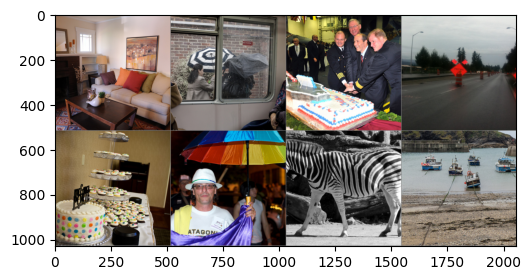

In [19]:
batch = next(iter(train_dataloader))
print([batch["text"]])
grid = torchvision.utils.make_grid(batch["image"], nrow=4)
plt.figure(figsize=(12, 3))
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

In [6]:
pipe = StableDiffusionPipeline.from_pretrained(
    "sd-legacy/stable-diffusion-v1-5",
    variant="fp16",
    torch_dtype=torch.float16,
    device_map="balanced"
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [7]:
scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="linear")

In [8]:
unet = UNet2DConditionModel.from_pretrained(
    "sd-legacy/stable-diffusion-v1-5",
    subfolder="unet",
    torch_dtype=torch.float32,
)

unet.train()

assert unet.dtype == torch.float32
assert unet.training

In [9]:
lora_modules = [
    "to_q", "to_k", "to_v", "to_out.0", "proj_in", "proj_out",
    "ff.net.0.proj", "ff.net.2", "conv1", "conv2", "conv_shortcut",
    "downsamplers.0.conv", "upsamplers.0.conv", "time_emb_proj"
]

lora_config = LoraConfig(
    r=64,                   
    target_modules=lora_modules,
)

model = get_peft_model(unet, lora_config, adapter_name="ct").to("cuda")
model.enable_gradient_checkpointing()

In [10]:
from diffusers.optimization import get_cosine_schedule_with_warmup
optimizer = AdamW(model.parameters(), lr=1e-4)
num_training_steps = len(train_dataloader) * 1
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=(len(train_dataloader) * 1),
)

In [11]:
@torch.no_grad()
def prepare_batch(batch, pipe):
    """
    Предобработка батча картинок и текстовых промптов.
    Маппим картинки в латентное пространство VAE.
    Извлекаем эмбеды промптов с помощью текстового энкодера.

    Params:

    Return:
        latents: torch.Tensor([B, 4, 64, 64], dtype=torch.float16)
        prompt_embeds: torch.Tensor([B, 77, D], dtype=torch.float16)
    """

    # Токенизируем промпты
    text_inputs = pipe.tokenizer(
        batch['text'],
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )

    # Извлекаем эмбеды промптов с помощью текстового энкодера
    prompt_embeds = pipe.text_encoder(text_inputs.input_ids.cuda())[0]

    # Переводим картинки в латентное пространство VAE
    image = batch['image'].to("cuda", dtype=torch.float16)
    latents = pipe.vae.encode(image).latent_dist.sample()
    latents = latents * pipe.vae.config.scaling_factor
    return latents, prompt_embeds

In [12]:
%%bash
wandb login

wandb: Currently logged in as: andrew_tep to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [13]:
import wandb

wandb.init(
    project="lora_training",  
    entity="andrew_tep",   
    config={
        "learning_rate": 1e-4,
        "batch_size": 64,
        "epochs": 5,
    }
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: andrew_tep to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [14]:
def train(model, pipe, train_dataloader, device, num_grad_accum, scheduler, optimizer, lr_scheduler, num_epoch):
    losses = []
    global_step = 0
    torch.cuda.empty_cache()

    model.train()
    optimizer.zero_grad(set_to_none=True)
    
    for epoch in range(num_epoch):
        for i, batch in enumerate(tqdm(train_dataloader)):

            latents, prompt_embeds = prepare_batch(batch, pipe)

            noise = torch.randn(latents.shape).to(device)
            timesteps = torch.randint(0, scheduler.num_train_timesteps, (latents.size(0),), device=device).long()
            
            noisy_latents = scheduler.add_noise(latents, noise, timesteps)

            with torch.amp.autocast("cuda", torch.float16):
                outputs = model(
                    noisy_latents,
                    timesteps,
                    prompt_embeds,
                    return_dict=True
                )[0]

                loss = torch.nn.functional.mse_loss(outputs, noise)
            
            loss.backward()
            if i % num_grad_accum == 0:
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad(set_to_none=True)

                
            loss_value = loss.detach().item()
            wandb.log({"loss": loss_value, "epoch": epoch, "step": global_step})
            global_step+=1

            # print(f"Loss: {loss_value}")
            losses.append(loss_value)
    print(np.mean(losses))
    return losses

In [15]:
device = "cuda"
num_grad_accum = 2
num_epoch = 5
losses = train(model, pipe, train_dataloader, device, num_grad_accum, scheduler, optimizer, lr_scheduler, num_epoch)

  0%|          | 0/78 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

0.13763593891874337


In [ ]:
def visualize_images(images):
    assert len(images) == 4
    plt.figure(figsize=(12, 3))
    for i, image in enumerate(images):
        plt.subplot(1, 4, i+1)
        plt.imshow(image)
        plt.axis('off')

    plt.subplots_adjust(wspace=-0.01, hspace=-0.01)

model = model.half()
model.eval()

prompt = "A man wearing a hat is carrying an umbrella"
guidance_scale = 7.5
generator = torch.Generator("cuda").manual_seed(1)

num_steps = 50  

text_embeddings = pipe._encode_prompt(
    prompt,
    device="cuda",
    num_images_per_prompt=4, 
    do_classifier_free_guidance=True
).to(torch.float16)

latents = torch.randn((4, 4, 64, 64), device="cuda", dtype=torch.float32, generator=generator)
latents *= pipe.scheduler.init_noise_sigma
latents=latents.to(torch.float16)
pipe.scheduler.set_timesteps(num_steps, device="cuda")

for t in pipe.scheduler.timesteps:
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    with torch.no_grad():
        noise_pred = model(
            latent_model_input,
            t,
            encoder_hidden_states=text_embeddings
        ).sample

    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

with torch.no_grad():
    images = pipe.decode_latents(latents)

visualize_images(images)